# Problem Statement

Credit Card payment default occurs when you fail to pay the Minimum Amount Due (MAD) on the credit card for a few consecutive months. Usually, the default notice is sent by the card issuer after 6 consecutive missed payments.

**Consequences of Credit card payment default**

- Lawful Punishments
- Suspended Credit Card Account
- Detrimental Effect on Credit Score
- High-Interest Rates
- Asset Possession

In this project we classify customers as potential defaulters given personal and 6 months banking details.

**Variables**

- **Credit Limit**: Amount of the given credit (in dollars): it includes both the individual consumer credit and his/her family (supplementary) credit
- **Sex** (1=male; 2=female)
- **Education** (1=graduate school; 2=university; 3=high school; 4=other)
- **Marital Status** (1=married; 2=single; 3=others)
- **Age** (years)
- **History of past payment**: The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above
- **Amount of bill statement** (dollars) for past 6 months
- **Amount of previous payment** for the past 6 months

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import make_scorer,precision_recall_curve,auc,f1_score
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from matplotlib.gridspec import GridSpec
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Data Summary

In [3]:
data=pd.read_csv('../input/default-of-credit-card-clients-dataset/UCI_Credit_Card.csv')

In [4]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

In [6]:
data[['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE','default.payment.next.month']].describe().T

,count,mean,std,min,25%,50%,75%,max
LIMIT_BAL,30000.0,167484.322667,129747.661567,10000.0,50000.0,140000.0,240000.0,1000000.0
SEX,30000.0,1.603733,0.489129,1.0,1.0,2.0,2.0,2.0
EDUCATION,30000.0,1.853133,0.790349,0.0,1.0,2.0,2.0,6.0
MARRIAGE,30000.0,1.551867,0.521970,0.0,1.0,2.0,2.0,3.0
AGE,30000.0,35.485500,9.217904,21.0,28.0,34.0,41.0,79.0
default.payment.next.month,30000.0,0.221200,0.415062,0.0,0.0,0.0,0.0,1.0


In [7]:
data[['PAY_0','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].describe().T

,count,mean,std,min,25%,50%,75%,max
PAY_0,30000.0,-0.016700,1.123802,-2.0,-1.0,0.0,0.0,8.0
PAY_2,30000.0,-0.133767,1.197186,-2.0,-1.0,0.0,0.0,8.0
PAY_3,30000.0,-0.166200,1.196868,-2.0,-1.0,0.0,0.0,8.0
PAY_4,30000.0,-0.220667,1.169139,-2.0,-1.0,0.0,0.0,8.0
PAY_5,30000.0,-0.266200,1.133187,-2.0,-1.0,0.0,0.0,8.0
PAY_6,30000.0,-0.291100,1.149988,-2.0,-1.0,0.0,0.0,8.0


In [8]:
data[['BILL_AMT1', 'BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].describe().T

,count,mean,std,min,25%,50%,75%,max
BILL_AMT1,30000.0,51223.330900,73635.860576,-165580.0,3558.75,22381.5,67091.00,964511.0
BILL_AMT2,30000.0,49179.075167,71173.768783,-69777.0,2984.75,21200.0,64006.25,983931.0
BILL_AMT3,30000.0,47013.154800,69349.387427,-157264.0,2666.25,20088.5,60164.75,1664089.0
BILL_AMT4,30000.0,43262.948967,64332.856134,-170000.0,2326.75,19052.0,54506.00,891586.0
BILL_AMT5,30000.0,40311.400967,60797.155770,-81334.0,1763.00,18104.5,50190.50,927171.0
BILL_AMT6,30000.0,38871.760400,59554.107537,-339603.0,1256.00,17071.0,49198.25,961664.0


**Any time a negative dollar amount shows up on a credit card balance, it means the bank owes the account holder money. The negative balance will zero out or become a positive balance as the cardholder charges additional purchases.**

In [9]:
data[['PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].describe().T

,count,mean,std,min,25%,50%,75%,max
PAY_AMT1,30000.0,5663.580500,16563.280354,0.0,1000.00,2100.0,5006.00,873552.0
PAY_AMT2,30000.0,5921.163500,23040.870402,0.0,833.00,2009.0,5000.00,1684259.0
PAY_AMT3,30000.0,5225.681500,17606.961470,0.0,390.00,1800.0,4505.00,896040.0
PAY_AMT4,30000.0,4826.076867,15666.159744,0.0,296.00,1500.0,4013.25,621000.0
PAY_AMT5,30000.0,4799.387633,15278.305679,0.0,252.50,1500.0,4031.50,426529.0
PAY_AMT6,30000.0,5215.502567,17777.465775,0.0,117.75,1500.0,4000.00,528666.0


In [10]:
data.isnull().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64

# Data Cleaning

In [11]:
data.rename(columns={'default.payment.next.month':'default','PAY_0':'PAY_1'},inplace=True)

In [12]:
data['SEX'].value_counts()

2    18112
1    11888
Name: SEX, dtype: int64

**SEX: (1=male, 2=female)**

In [13]:
fil = (data['EDUCATION'] == 5) | (data['EDUCATION'] == 6) | (data['EDUCATION'] == 0)
data.loc[fil, 'EDUCATION'] = 4
data['EDUCATION'].value_counts()

2    14030
1    10585
3     4917
4      468
Name: EDUCATION, dtype: int64

**EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others)**

In [14]:
data.loc[data['MARRIAGE']==0, 'MARRIAGE'] = 3
data['MARRIAGE'].value_counts()

2    15964
1    13659
3      377
Name: MARRIAGE, dtype: int64

**MARRIAGE: Marital status (1=married, 2=single, 3=others)**

In [15]:
for i in range(1,7):
    col='PAY_'+str(i)
    fil = (data[col] == -2) | (data[col] == -1) 
    data.loc[fil, col] = 0

**REPAYMENT STATUS: (0=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above)**

In [16]:
data=data[data["LIMIT_BAL"]<=500000.0]

- **Very people have LIMIT_BAL greater then 500000.0 around 100, there we will take only those instances where LIMIT_BAL is lower then or equal to 500000.0.**

# Exploratary Data Analysis

In [17]:
copy=data.copy(deep=True)

In [18]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize']=(12,8)

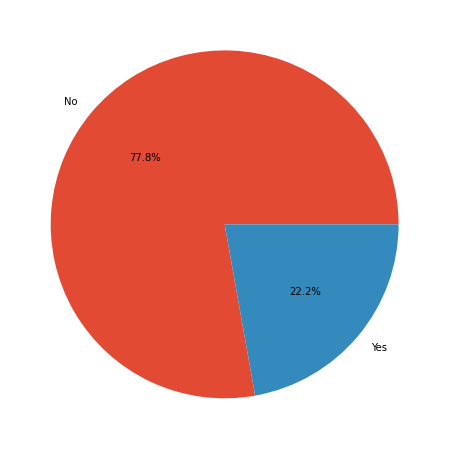

In [19]:
inter=data['default'].value_counts()
plt.pie(inter,labels=['No','Yes'],autopct='%0.1f%%',radius=1);
plt.savefig("image1.png")

- **There is imbalance in class distribution**
- **We will use sampling method,cost-sensitive learning to see if they increase the performance of algorithm**

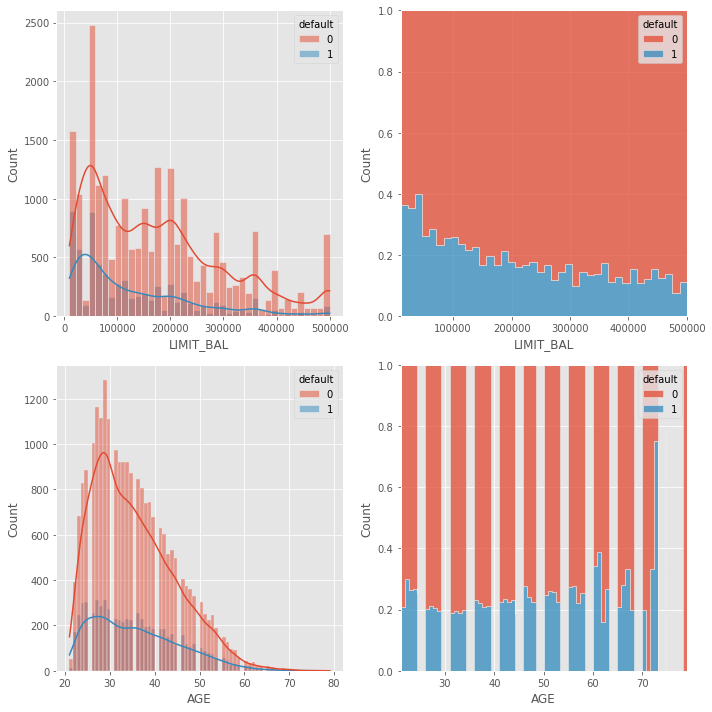

In [20]:
fig,axes=plt.subplots(2,2,figsize=(10,10))
cols=['LIMIT_BAL','AGE']
for i,col in enumerate(cols):
    if col=='PAY_AMT1':
        x=np.log1p(data[col])
    else:
        x=data[col]
        
    sns.histplot(x=x,hue='default',data=data,kde=True,ax=axes[i,0]);
    sns.histplot(x=x,hue='default',data=data,multiple="fill",ax=axes[i,1],element="step");
    
plt.tight_layout()
plt.savefig("image2.png")

- **Numerical variable have non-gaussian distribution, therefore we will use power transformer to transform them to gaussian like.**
- **As the LIMIT Balance increases the proportion of defaulters decreases, there is monotonically decreasing ratio of defaulters with increasing LIMIT Balance.**


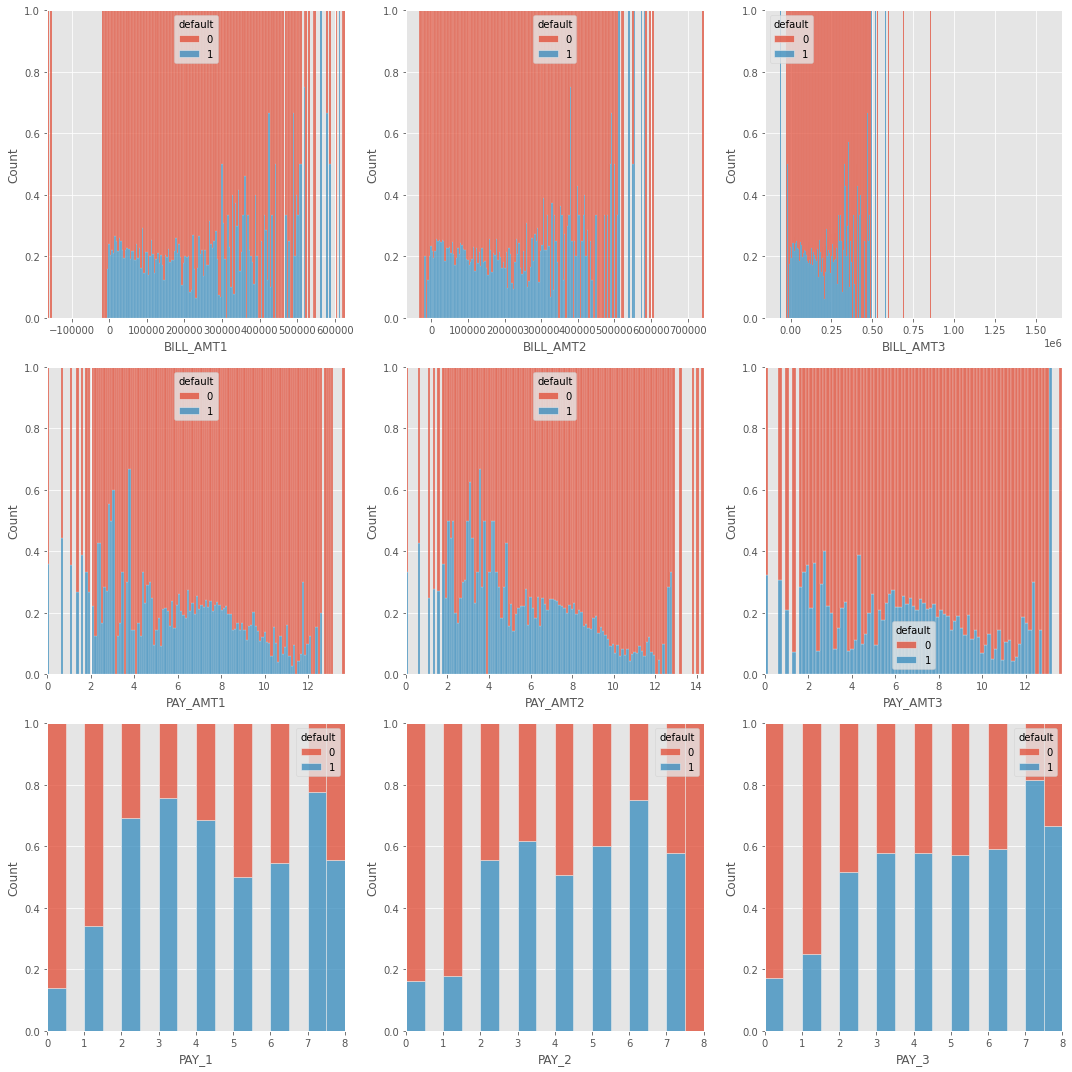

In [21]:
fig,axes=plt.subplots(3,3,figsize=(15,15))
cols=['BILL_AMT', 'PAY_AMT','PAY_']
for i,col in enumerate(cols):
    for j in range(1,4):
        inter=col+str(j)
        if 'PAY_AMT' in inter:
            x=np.log1p(data[inter])
        else:
            x=data[inter]
        
        sns.histplot(x=x,hue='default',data=data,multiple="fill",ax=axes[i,j-1]);
    
plt.tight_layout()
plt.savefig("image3.png")

- **When BILL AMOUNT is negative,that means bank owns card holder money, with positive BILL AMOUNT the ratio of defaulters increases with increase in BILL AMOUNT, larger the sum of money to be repayed more will the chances of defaulting.**
- **The Pay (Repayment Status) shows that with one month repayment delay, there is large increase in ratio of card defaulting. The same pattern is exhibited by all Pay variables.**
- **With increasing PAY AMOUNT the ratio of defaulting decreases, as the borrower is rapaying the amount preventing bill amount from accumulating and becoming untenable.**

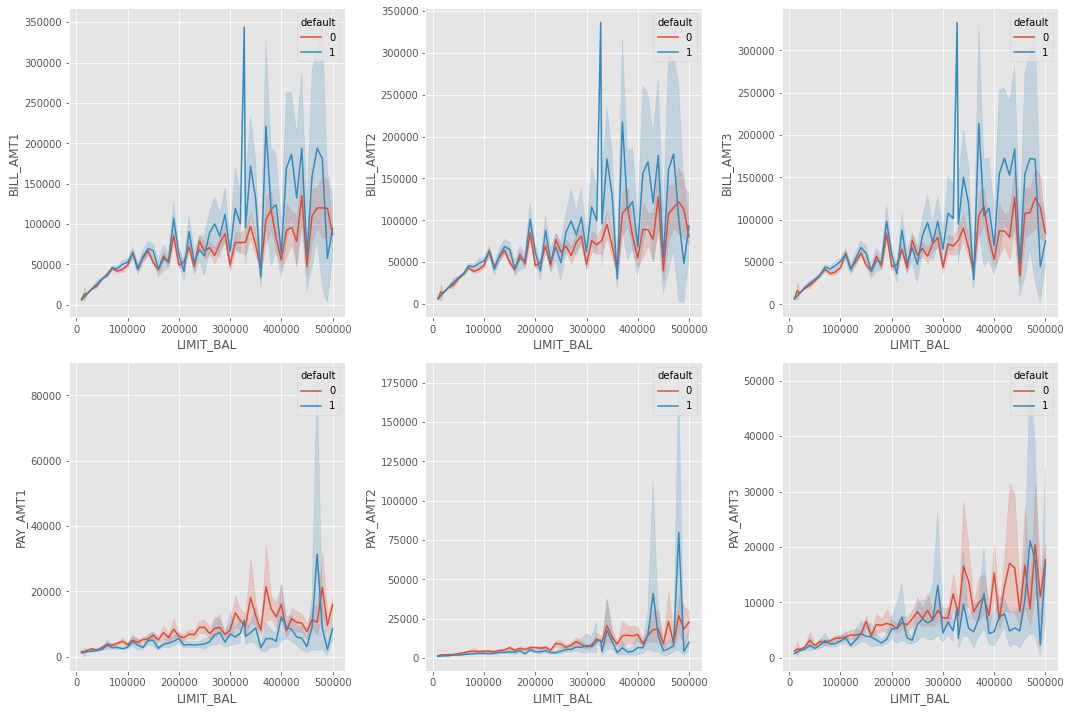

In [22]:
fig,axes=plt.subplots(2,3,figsize=(15,10))
cols=['BILL_AMT', 'PAY_AMT']
for i,col in enumerate(cols):
    for j in range(1,4):
        inter=col+str(j)
    
        sns.lineplot(x='LIMIT_BAL',y=inter, hue="default",data=data,ax=axes[i,j-1]);
    
plt.tight_layout()
plt.savefig("image4.png")

- **As the LIMIT BALANCE increases the BILL AMOUNT for defaulters have higher mean then BILL AMOUNT for non-defaulters, while they have same distribution for lower LIMIT BALANCE(0-250000).**
- **Card Holders with high PAY AMOUNT have lower default then with low PAY AMOUNT.**

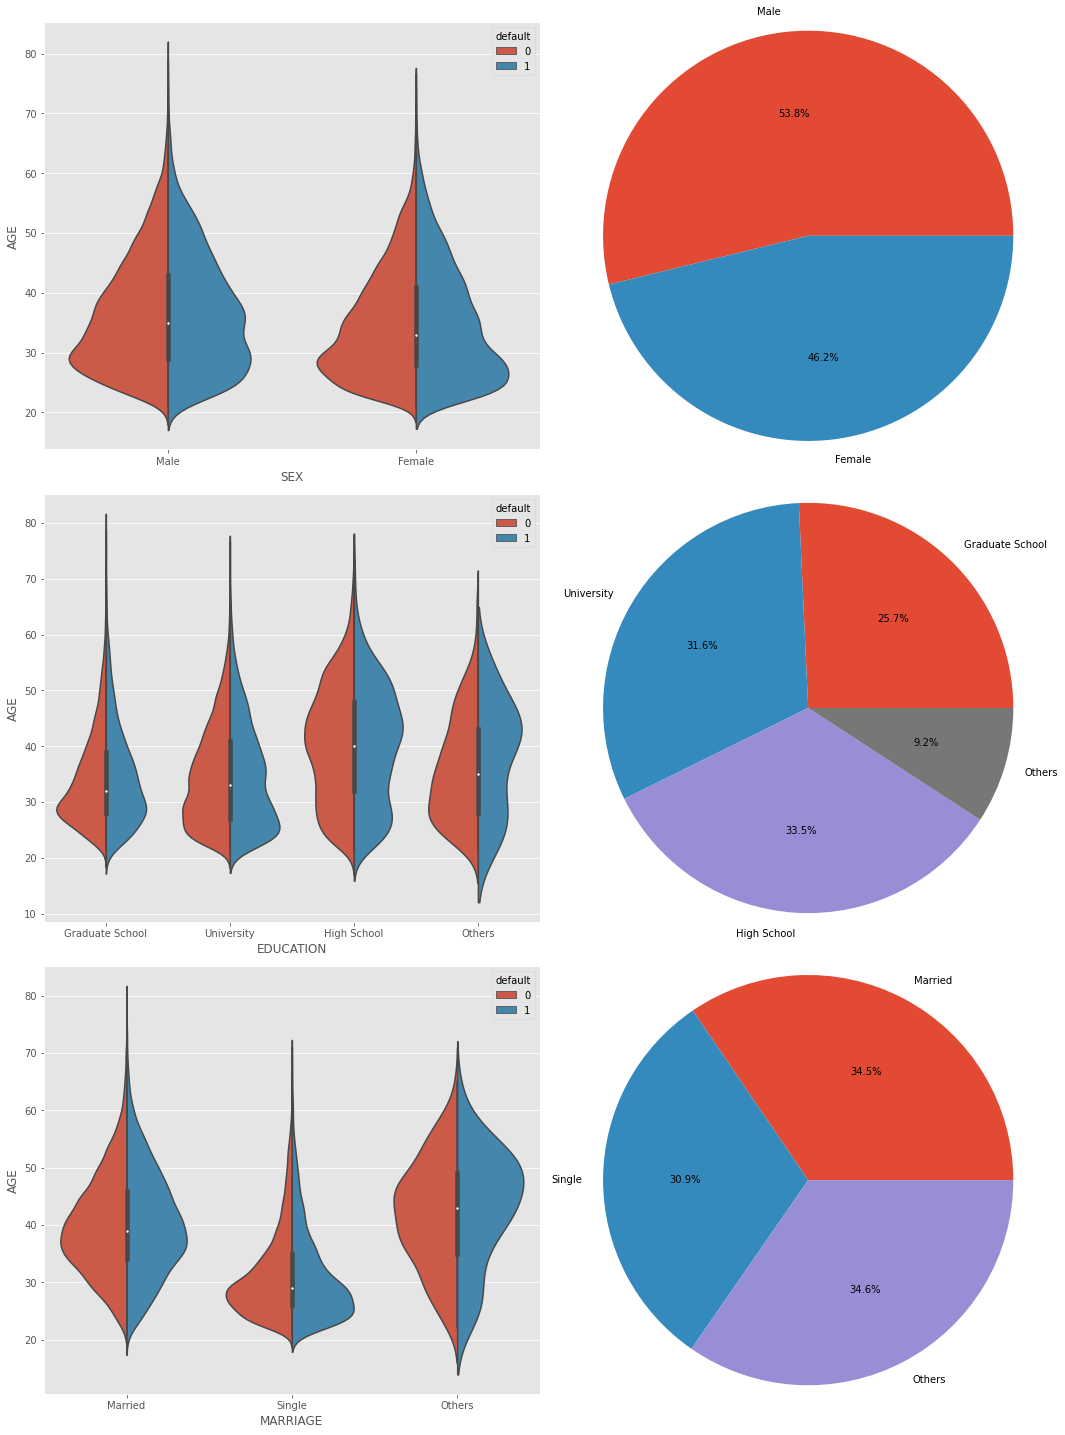

In [23]:
labels={"SEX":{1:"Male",2:"Female"},
        "EDUCATION":{1:"Graduate School",2:"University",3:"High School",4:"Others"},
        "MARRIAGE":{1:"Married",2:"Single",3:"Others"}}

fig,axes=plt.subplots(3,2,figsize=(15,20))
cols=['SEX', 'EDUCATION', 'MARRIAGE']

for i,col in enumerate(cols):
    inter=data.groupby(col)['default'].mean()
    
    sns.violinplot(x=col,y="AGE", hue="default",split=True, data=data,ax=axes[i,0]);
    axes[i,0].set_xticklabels(labels=labels[col].values())
    axes[i,1].pie(inter,labels=labels[col].values(),autopct='%0.1f%%',radius=1.2);
    
plt.tight_layout()
plt.savefig("image5.png")

- **Women are more susceptible to defaulting then men as can be seen from data 53.8%(female) against 46.2%(male).**
- **Single person has lower defaulting ratio in comparison to married,divorced,live-in  person as they have less expenses and not responsible for family,children.**

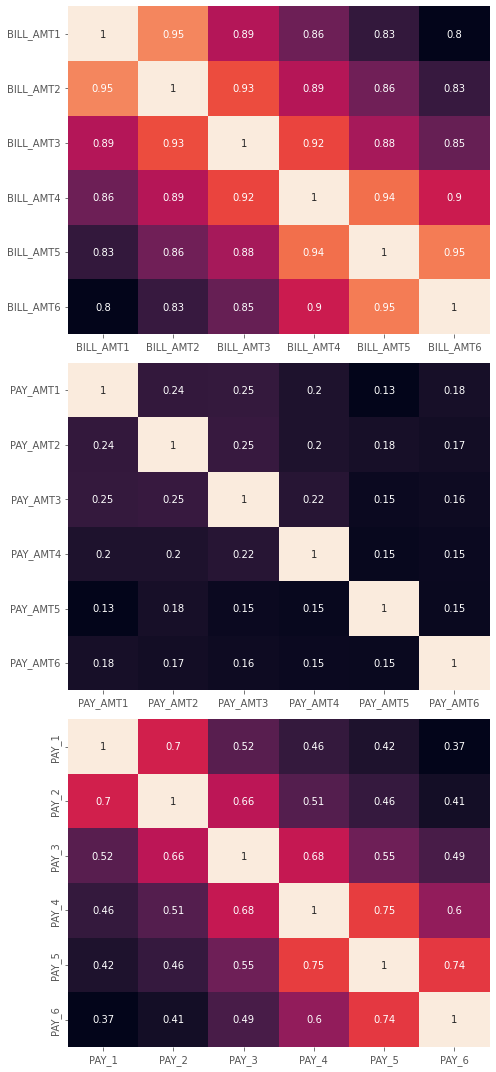

In [24]:
fig,axes=plt.subplots(3,1,figsize=(7,15))
cols=['BILL_AMT', 'PAY_AMT','PAY_']

for i,col in enumerate(cols):
    select=[col+str(j) for j in range(1,7)]
    sns.heatmap(data[select].corr(),cbar=False,annot=True, ax=axes[i]);
    
plt.tight_layout()
plt.savefig("image6.png")

- **Repayment Status variables have strong correlation with the previous months repayment status variables.**
- **Bill_AMT variables are highly correlated, as the Bill_AMT depends on previous money owned plus money drawn present month due to which it has string correlation with previous month Bill_AMT.**

# Data Preprocessing

In [25]:
# converting age into categorical variable

data['AGE']=pd.cut(data['AGE'],bins=range(20,85,5),labels=range(len(range(20,85,5))-1))

In [26]:
X=data.drop(['ID','default'],axis=1)
y=data['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [27]:
numeric_col=['LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2','BILL_AMT3', 'BILL_AMT4',
             'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4',
             'PAY_AMT5', 'PAY_AMT6']

categorical_col=['SEX','AGE', 'EDUCATION', 'MARRIAGE', 'PAY_1',
                 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

In [28]:
transformer=ColumnTransformer([('scaled',PowerTransformer(),numeric_col)],remainder='passthrough')
transformer.fit(X_train)

columns=numeric_col+categorical_col
X_train=pd.DataFrame(transformer.transform(X_train),columns=columns)
X_test=pd.DataFrame(transformer.transform(X_test),columns=columns)

# Algorithm Spot Checking

In [29]:
def get_models():
    
    models,names=[],[]
    
    models.append(LogisticRegression(random_state=42,n_jobs=-1))
    names.append('lr')
    
    models.append(KNeighborsClassifier(n_jobs=-1))
    names.append('knn')
    
    models.append(RandomForestClassifier(random_state=42,n_jobs=-1))
    names.append('rfc')
    
    models.append(XGBClassifier(random_state=42,n_jobs=-1))
    names.append('xgb')
    
    models.append(LGBMClassifier(random_state=42,n_jobs=-1))
    names.append('lgb')
    
    return names, models

In [30]:
def evaluate(X,y,names,models):
    
    results=[]
    for i in range(len(models)):
        cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
        scores=cross_val_score(models[i],X_train,y_train,scoring="roc_auc",cv=cv,n_jobs=-1)
        results.append(scores)
        
    plt.boxplot(results,labels=names,showmeans=True);

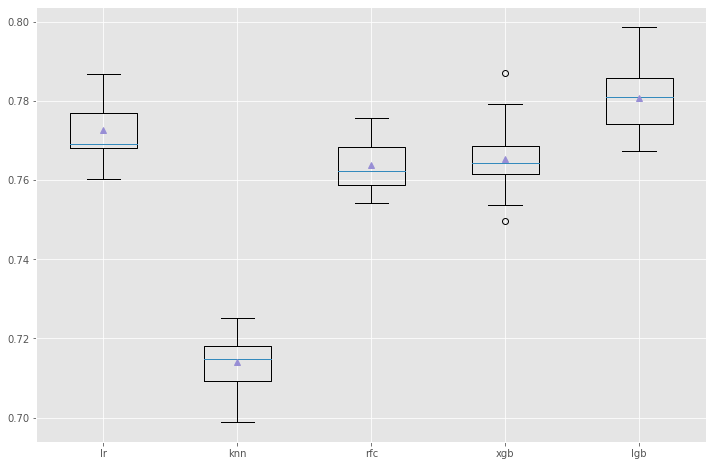

In [31]:
names, models=get_models()
evaluate(X_train,y_train,names,models)
plt.savefig("image7.png")

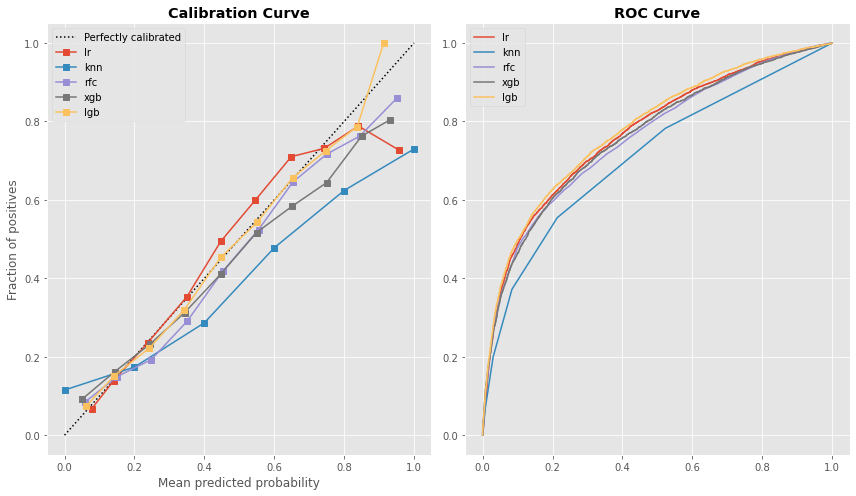

In [32]:
names,models=get_models()
fig,axes=plt.subplots(1,2,figsize=(12,7))

for i in range(len(models)):
    importance=[]
    probability=pd.Series()
    
    for train_idx,val_idx in StratifiedKFold(n_splits=5,shuffle=True, random_state=42).split(X_train,y_train):
        model=models[i].fit(X_train.iloc[train_idx,:],y_train.iloc[train_idx])
        y_proba=model.predict_proba(X_train.iloc[val_idx,:])[:,1]
    
        inter=pd.Series(data=y_proba,index=val_idx)
        probability=pd.concat([probability,inter])
        
    y_proba=probability.sort_index().values
    y_true=y_train
    
    ax=axes[0]
    CalibrationDisplay.from_predictions(y_true,y_proba,n_bins=10,ax=ax,name=names[i]);
        
    ax=axes[1]
    fpr,tpr,thresh=roc_curve(y_true,y_proba)
    ax.plot(fpr,tpr,label=names[i])
            
axes[0].set_title(f"Calibration Curve",fontweight="bold")
axes[0].legend()
axes[1].set_title(f"ROC Curve",fontweight="bold")
axes[1].legend()
plt.tight_layout()
plt.savefig("image8.png")

- **LightGBM performs best among other models.**
- **KNNClassifier performs poorly and is highly underconfident for predicting positive class.**
- **LightGBM,XGB,Random Forest, Logistic Regression classifiers have learned the underlying structure but are underconfident with high probabilities, therefore there performance can be increased by using probabaility calibration.**

# Cost Sensitive Learning

In [33]:
xgb_weights=len(y_train[y_train==1])/len(y_train[y_train==0])

def cost_sensitive_models():
    
    models,names=[],[]
    
    models.append(LogisticRegression(class_weight="balanced",random_state=42,n_jobs=-1))
    names.append('lr')
    
    models.append(RandomForestClassifier(class_weight='balanced',random_state=42,n_jobs=-1))
    names.append('rfc')
    
    models.append(XGBClassifier(scale_pos_weight=xgb_weights,random_state=42,n_jobs=-1))
    names.append('xgb')
    
    models.append(LGBMClassifier(class_weight='balanced',random_state=42,n_jobs=-1))
    names.append('lgb')
    
    return names,models

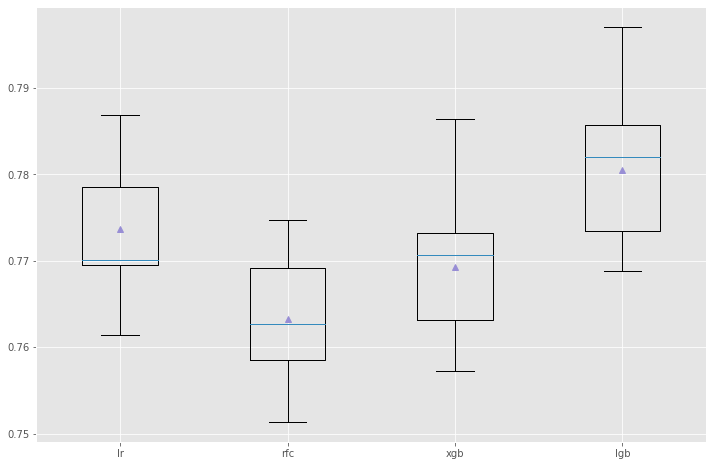

In [34]:
names,models=cost_sensitive_models()
evaluate(X_train,y_train,names,models)
plt.savefig("image9.png")

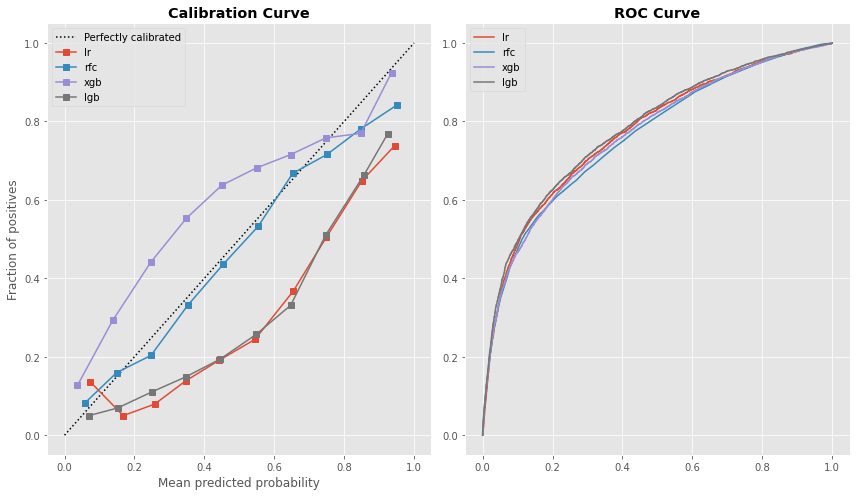

In [35]:
names,models=cost_sensitive_models()
fig,axes=plt.subplots(1,2,figsize=(12,7))

for i in range(len(models)):
    importance=[]
    probability=pd.Series()
    
    for train_idx,val_idx in StratifiedKFold(n_splits=5,shuffle=True, random_state=42).split(X_train,y_train):
        model=models[i].fit(X_train.iloc[train_idx,:],y_train.iloc[train_idx])
        y_proba=model.predict_proba(X_train.iloc[val_idx,:])[:,1]
    
        inter=pd.Series(data=y_proba,index=val_idx)
        probability=pd.concat([probability,inter])
        
    y_proba=probability.sort_index().values
    y_true=y_train
    
    ax=axes[0]
    CalibrationDisplay.from_predictions(y_true,y_proba,n_bins=10,ax=ax,name=names[i]);
        
    ax=axes[1]
    fpr,tpr,thresh=roc_curve(y_true,y_proba)
    ax.plot(fpr,tpr,label=names[i])
            
axes[0].set_title(f"Calibration Curve",fontweight="bold")
axes[0].legend()
axes[1].set_title(f"ROC Curve",fontweight="bold")
axes[1].legend()
plt.tight_layout()
plt.savefig("image10.png")

- **Cost Sensitive Learning doesn't result into improvement in performance.**
- **Also the class imbalance is not so severe, it is (80,20) therefore instead of accuracy we can use gmeans to estimate the performance of models.**
- **Using cost sensitive learning results into XGBoost become overconfident and LightGBM becomes underconfident.It points to boosting algorithm propensity to overfitting and performing poorly on test dataset.**

# Feature Importance

In [36]:
from sklearn.metrics import roc_auc_score

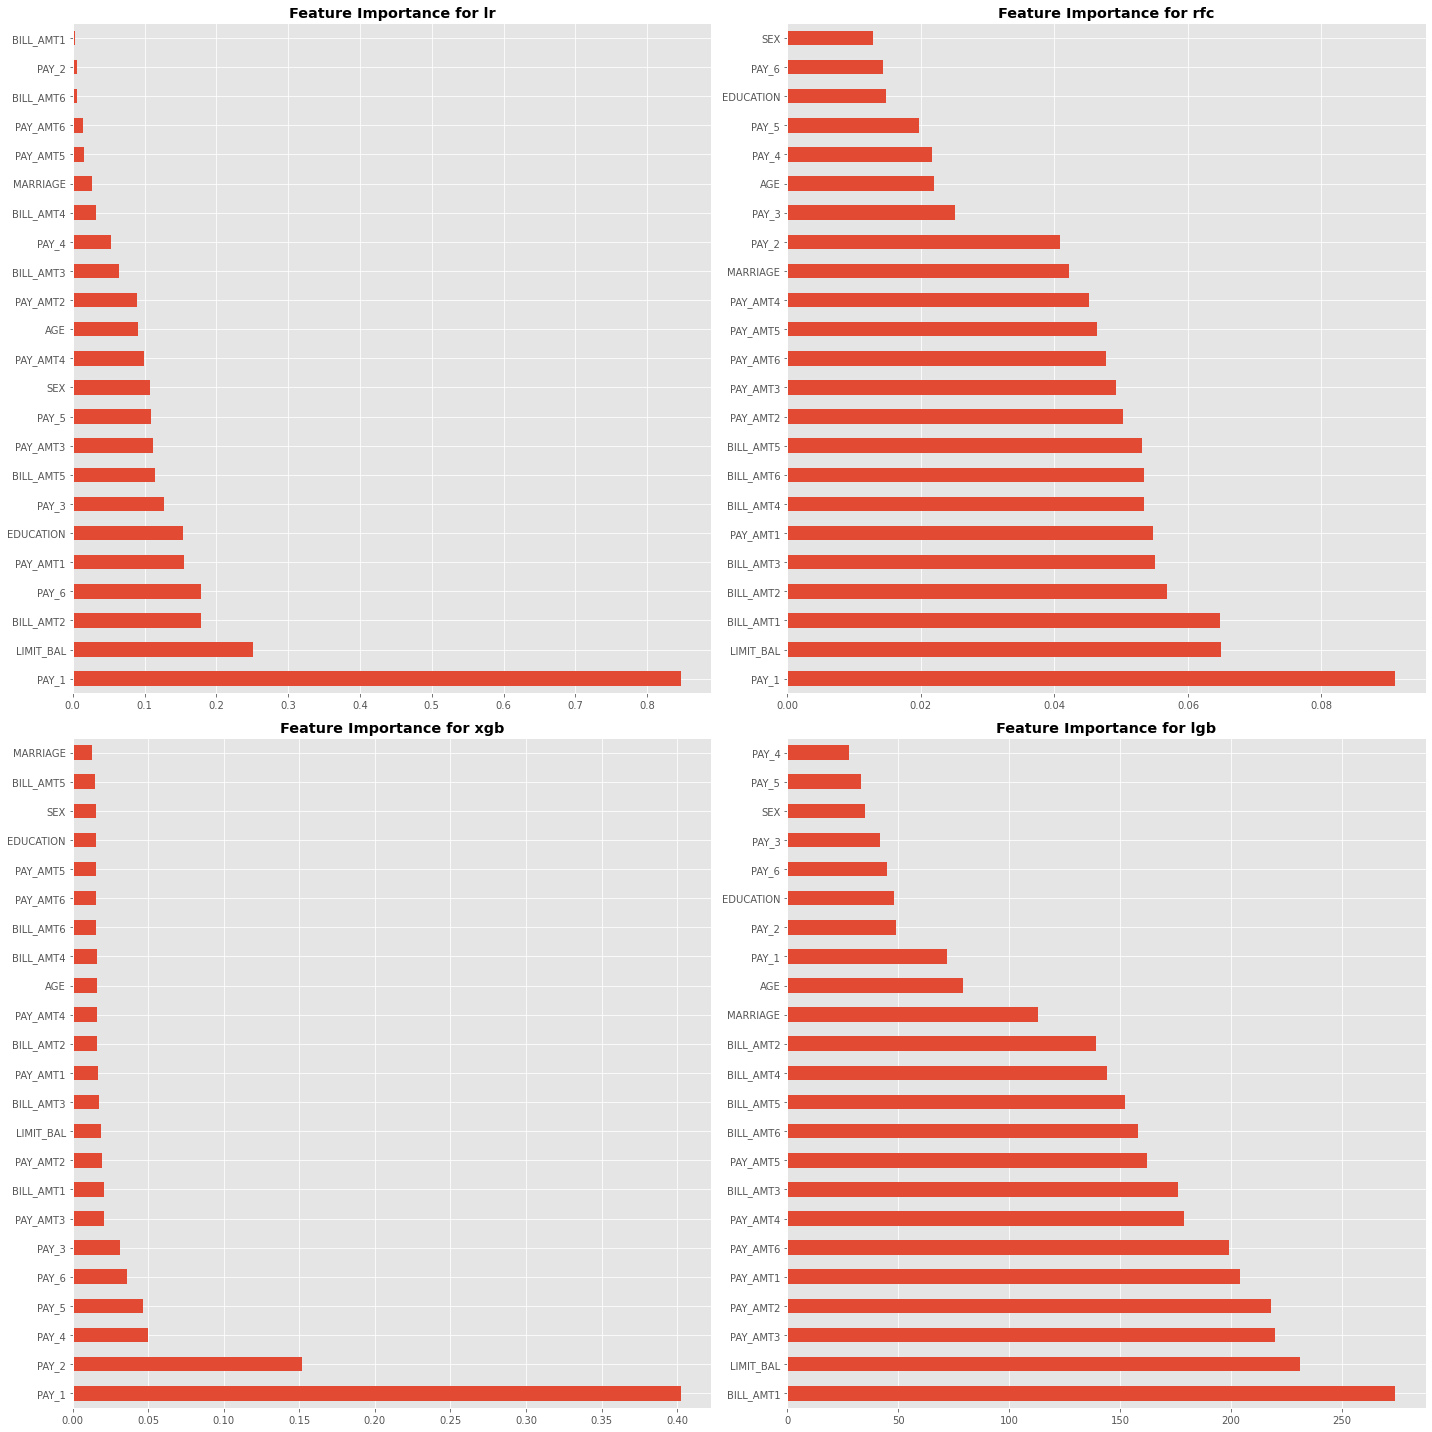

In [37]:
names=['lr','rfc','xgb','lgb']
models=[LogisticRegression(random_state=42,n_jobs=-1),
        RandomForestClassifier(random_state=42,n_jobs=-1),
        XGBClassifier(random_state=42,n_jobs=-1),
        LGBMClassifier(random_state=42,n_jobs=-1)]

fig,axes=plt.subplots(2,2,figsize=(20,20))
ax=axes.flatten()

for i in range(len(models)):
    model=models[i].fit(X_train,y_train)
        
    if names[i]=='lr':
        fi=pd.Series(np.abs(model.coef_[0]),index=columns).sort_values(ascending=False)
    else:
        fi=pd.Series(model.feature_importances_,index=columns).sort_values(ascending=False)
        
    fi.plot(kind='barh',ax=ax[i])
    ax[i].set_title(f"Feature Importance for {names[i]}",fontweight="bold")

plt.tight_layout()
plt.savefig("image11.png")

**All four models accord differnt importance to features, we can use ensembling to get a model that combines the strength of each model**

# Ensembling

In [38]:
lgb_params={"n_estimators": 237,
            "max_depth": 7,
            "learning_rate": 0.015837031559118753,
            "subsample": 0.508540663048167,
            "colsample_bytree": 0.5554487413172255,
            "reg_lambda": 0.011128853174905732}

xgb_params={"n_estimators": 155,
            "max_depth": 5,
            "learning_rate": 0.03240382987804184,
            "subsample": 0.7277683560359076,
            "colsample_bytree": 0.5054900274074635,
            "reg_lambda": 0.01947087112740539}
    
rf_params={"n_estimators": 400,
           "max_depth": 8,
           "max_samples": 0.44693385883212244,
           "min_samples_split": 17,
           "max_features": "auto"}

lr_params={"C": 3.535413259410318,
           "penalty": "l2"}

In [39]:
models={"LGBMClassifier":LGBMClassifier(**lgb_params,random_state=42,n_jobs=-1),
        "XGBClassifier":XGBClassifier(**xgb_params,random_state=42,n_jobs=-1),
        "RandomForestClassifier":RandomForestClassifier(**rf_params,random_state=42,n_jobs=-1),
        "LogisticRegrssion":LogisticRegression(**lr_params,random_state=42,n_jobs=-1)}

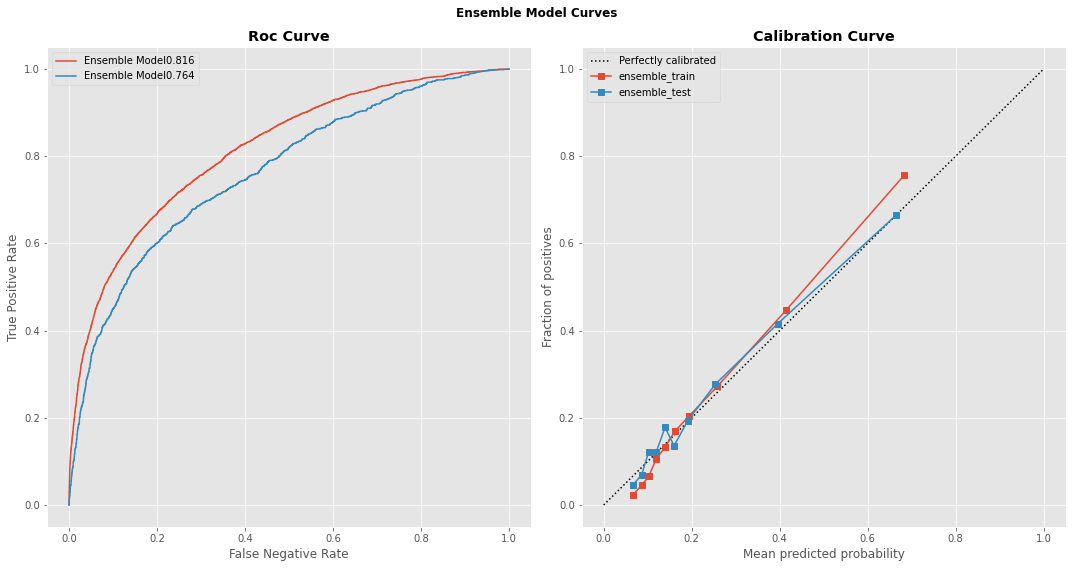

In [40]:
fig,axes=plt.subplots(1,2,figsize=(15,8))
pred_train=[0 for i in range(len(y_train))]
pred_test=[0 for i in range(len(y_test))]

for i in models.keys():
    model=models[i]
    model.fit(X_train,y_train)
    
    y_proba_train=model.predict_proba(X_train)
    pred_train+=y_proba_train[:,1]/len(models);
    y_proba_test=model.predict_proba(X_test)
    pred_test+=y_proba_test[:,1]/len(models)

labels=['train','test']
pair=((y_train,pred_train),(y_test,pred_test))

for i,dataset in enumerate(pair):
    # Roc Curve
    score=roc_auc_score(*dataset)
    fpr,tpr,threshold=roc_curve(*dataset)
    axes[0].plot(fpr,tpr,label="Ensemble Model"+str(round(score,3)));
    
    #Calibration Curve
    CalibrationDisplay.from_predictions(*dataset,n_bins=10,name="ensemble_"+labels[i],
                                        ax=axes[1],strategy="quantile");
    
axes[0].set_title("Roc Curve",fontweight="bold")
axes[0].set_xlabel("False Negative Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].legend()
axes[1].set_title("Calibration Curve",fontweight="bold")
axes[1].legend()
plt.suptitle("Ensemble Model Curves",fontweight="bold")
plt.tight_layout()
plt.savefig("image12.png")

- **I have used optuna for hyperparameter tuning each model. The best hyperparameters determined will be used to build ensemble.**
- **Though the ensemble model has lower performance then lgbm and xgb on train dataset, but have same performance on test datasets, lower difference between train and test datasets performance.**
- **Instead of average ensemble, we can also use weighted ensembling or stacking.**

# Threshold Moving

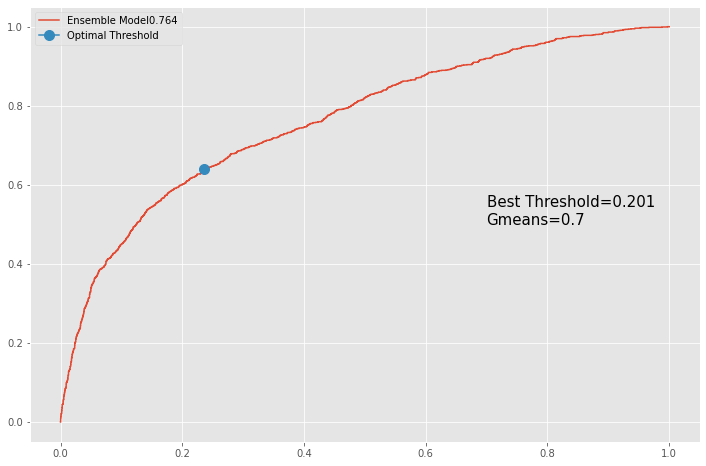

In [41]:
#Determing Optimal Threshold

fpr,tpr,threshold=roc_curve(y_test,pred_test)
gmeans=np.sqrt(tpr*(1-fpr))
idx=np.argmax(gmeans)

axes=plt.subplot(1,1,1)
axes.plot(fpr,tpr,label="Ensemble Model"+str(round(score,3)));
axes.plot(fpr[idx],tpr[idx],label="Optimal Threshold",marker="o",markersize=10);
plt.text(0.7,0.5,f"Best Threshold={round(threshold[idx],3)}\nGmeans={round(gmeans[idx],3)}",dict(size=15));
plt.legend();
plt.savefig("image13.png")

In [42]:
y_pred=(pred_test>=threshold[idx])
print(f'Classification_report: \n\n {classification_report(y_test,y_pred)}')

Classification_report: 

               precision    recall  f1-score   support

           0       0.88      0.76      0.82      4636
           1       0.44      0.64      0.52      1323

    accuracy                           0.74      5959
   macro avg       0.66      0.70      0.67      5959
weighted avg       0.78      0.74      0.75      5959



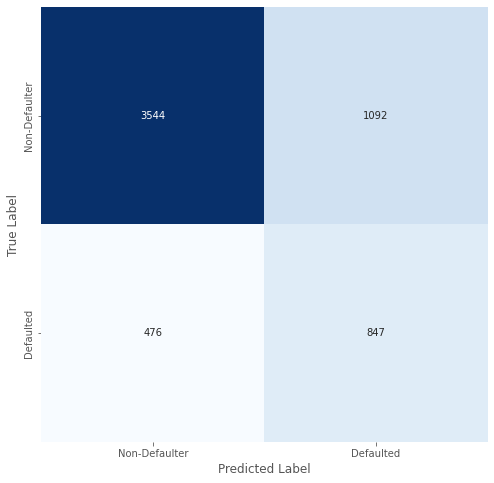

In [43]:
plt.figure(figsize=(8,8))

val=['Non-Defaulter','Defaulted']
data=pd.DataFrame(confusion_matrix(y_test,y_pred),columns=val,index=val)

sns.heatmap(data,annot=True,cbar=False,cmap='Blues',fmt='g');
plt.xlabel('Predicted Label');
plt.ylabel('True Label')
plt.savefig("image14.png");